In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error


import pmdarima as pm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('monthly_milk_production.csv', parse_dates = ['Date'], index_col = 'Date')
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [ ]:
# Print the data types of all columns
print(df.dtypes)

# Print a concise summary of the DataFrame
df.info()

# Print the data type of the index
print(df.index.dtype)

In [ ]:
df = pd.read_csv('monthly_milk_production.csv')
df.dtypes

In [ ]:
df.describe()

In [ ]:
df.isna().sum()

In [ ]:
df.plot(figsize = (10,5))
plt.title('Monthly Milk Production')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2)
plt.show

In [ ]:
decomposition = seasonal_decompose(df['Production'], period = 12, model = 'additive')
plt.rcParams['figure.figsize'] = 10, 5
decomposition.plot()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df['Production'], lags = 40, ax = ax1)
ax2 = plot_pacf(df['Production'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
def adfuller_test(production):
    result = adfuller(production)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, hence REJECT Ho. and the series is Stationary')
    else:
        print('Weak evidence against null hypothesis, hence ACCEPT Ho. and the series is Not Stationary.')

In [ ]:
adfuller_test(df['Production'])


In [ ]:
df1 = df.diff().diff(12).dropna()


In [ ]:
adfuller_test(df1['Production'])


In [ ]:
df1.plot(figsize=(10,5))
plt.title('Monthly Milk Production')
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = autocorrelation_plot(df['Production'], ax = ax1)
ax1.set_title('Non - Stationary Data')

ax2 = autocorrelation_plot(df1['Production'], ax = ax2)
ax2.set_title('Stationary Data')

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df1['Production'], lags = 40, ax = ax1)
ax2 = plot_pacf(df1['Production'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

In [ ]:
model = pm.auto_arima(df['Production'], d = 1, D = 1,
                      seasonal = True, m = 12, 
                      start_p = 0, start_q = 0, max_order = 6, test = 'adf', trace = True)

In [ ]:
model.summary()


In [3]:
train = df[:int(0.85*(len(df)))]
test = df[int(0.85*(len(df))):]

train.shape, test.shape

((142, 1), (26, 1))

In [5]:
train

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1973-06-01,924
1973-07-01,881
1973-08-01,837


In [6]:
model = SARIMAX(train['Production'],
                order = (1,1,0), seasonal_order = (0,1,1,12))
results = model.fit(disp = True)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -445.603
Date:                              Fri, 02 Aug 2024   AIC                            897.205
Time:                                      22:20:08   BIC                            905.785
Sample:                                  01-01-1962   HQIC                           900.691
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.6158      0.086     -7.163      0.000      -0.784      -0.447
sigma2        56.0243      5.765      9.719      0.000      44.726      67.323
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                40.04
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                             0.86
Prob(H) (two-sided):                  0.71   Kurtosis:                         5.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [4]:
import joblib

# Save the fitted model using joblib
joblib.dump(results, 'sarimax_model.joblib')

# To load the model later
loaded_results = joblib.load('sarimax_model.joblib')

# You can then use loaded_results as you would use results
print(loaded_results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                           Production   No. Observations:                  142
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -445.603
Date:                              Sat, 03 Aug 2024   AIC                            897.205
Time:                                      13:45:39   BIC                            905.785
Sample:                                  01-01-1962   HQIC                           900.691
                                       - 10-01-1973                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.087     -3.149      0.002      -0.443      -0.103
ma.S.L12      -0.61

In [ ]:
loaded_results.plot_diagnostics(figsize = (15, 5))
plt.subplots_adjust(hspace = 0.5)
plt.show()

In [21]:
end

167

In [5]:
start = len(train)
end = len(train) + len(test) - 1
predictions = loaded_results.predict(start = start, end = end, dynamic = False, typ = 'levels').rename('SARIMA(1,1,0)(0,1,1,12) Test Predictions')

In [6]:
for i in range(len(predictions)):
    print(f"predicted = {predictions[i]:<11.10}, expected = {test['Production'][i]}")

predicted = 752.7789608, expected = 760
predicted = 791.7112655, expected = 802
predicted = 816.6069861, expected = 828
predicted = 775.7138796, expected = 778
predicted = 876.5424635, expected = 889
predicted = 891.6737754, expected = 902
predicted = 952.5816344, expected = 969
predicted = 923.4027755, expected = 947
predicted = 880.274709 , expected = 908
predicted = 839.9639142, expected = 867
predicted = 792.9111364, expected = 815
predicted = 798.3153889, expected = 812
predicted = 760.5296708, expected = 773
predicted = 799.3432196, expected = 813
predicted = 824.2713369, expected = 834
predicted = 783.3693925, expected = 782
predicted = 884.2003875, expected = 892
predicted = 899.3310416, expected = 903
predicted = 960.2390801, expected = 966
predicted = 931.0601722, expected = 937
predicted = 887.9321191, expected = 896
predicted = 847.6213206, expected = 858
predicted = 800.5685438, expected = 817
predicted = 805.9727961, expected = 827
predicted = 768.1870781, expected = 797


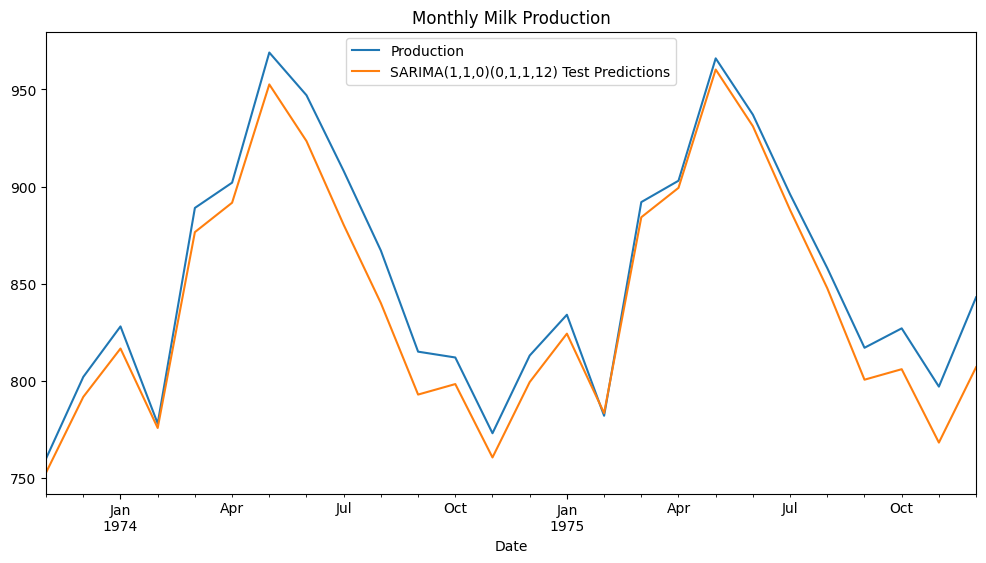

In [7]:
title = 'Monthly Milk Production'
ax = test['Production'].plot(legend = True, figsize = (12,6), title = title)
predictions.plot(legend = True)
ax.autoscale(axis = 'x',tight = True)

In [12]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Production'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Production'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Production'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Production'])/np.abs(test['Production']))*100 

evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.924043,14.062889,274.940636,1.649905


In [18]:
def eval_metrics(actual,predictions):
    mae=mean_absolute_error(actual, predictions)
    mse=mean_squared_error(actual, predictions)
    mape = np.mean(np.abs(predictions - actual)/np.abs(actual))*100 
    
    return mae, mse,mape

print(eval_metrics(test['Production'],predictions))
    

(14.062888849228928, 274.94063634808697, 1.6499054345183708)


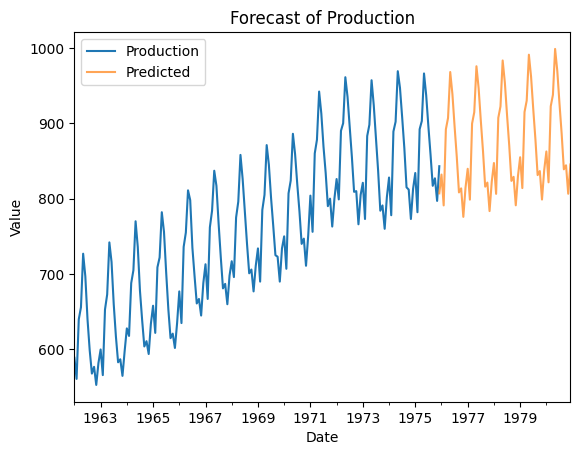

In [9]:
forecast = loaded_results.get_prediction(start = '1975-12-01', end = '1980-12-01')
idx = np.arange(len(forecast.predicted_mean))

forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()

fig, ax = plt.subplots()
df.plot(ax = ax, label='observed')
forecast_values.plot(ax = ax, label = 'Predicted', alpha = 0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Value')
plt.legend()
ax.set_title('Forecast of Production')
plt.show()
